# 4. Métricas y conclusiones

In [81]:
# Importar paquetes necesarios
import sys
sys.path.append('../..')

import string
import unicodedata
!pip install stop_words
from stop_words import get_stop_words

import sys
sys.path.append('../..')

import random
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve,recall_score

import matplotlib.pyplot as plt

You should consider upgrading via the 'C:\Users\Seven\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [82]:
# Datos descargados de http://jmcauley.ucsd.edu/data/amazon/
# ! unzip datasets.zip

import zipfile
with zipfile.ZipFile("datasets.zip", "r") as z:
    z.extractall(".")

In [83]:
datasets_path = 'datasets'
instruments_json = 'reviews_Musical_Instruments_5.json.gz'
df_instruments = pd.read_json(os.path.join(datasets_path, instruments_json), lines = True, compression = 'gzip')

# Subconjunto de características 'reviewText' y 'overall'
reviews = df_instruments[['reviewText','overall']]

reviews.head(3)

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5


C:\Users\Seven\AppData\Local\Temp\ipykernel_8860\609695815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.loc[:, 'sentiment'] = [0 if overall <= 3 else 1 for overall in reviews['overall']]


<AxesSubplot:title={'center':'Overall sentiment distribution'}>

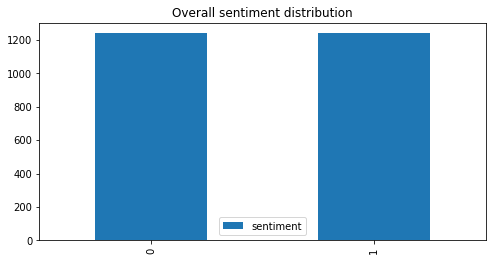

In [84]:
#  Personalmente creo que 3 es una review negativa
reviews.loc[:, 'sentiment'] = [0 if overall <= 3 else 1 for overall in reviews['overall']]
aux = pd.DataFrame(reviews['sentiment'].value_counts(sort=False).sort_index())
#ax = aux.plot(kind='bar', title='Overall sentiment distribution', figsize=(8, 4))

# Balanceo de clases
df_positive = reviews[reviews['sentiment'] == 1]
df_negative = reviews[reviews['sentiment'] == 0]

data_instruments = reviews.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), df_negative.shape[0])))

aux = pd.DataFrame(data_instruments['sentiment'].value_counts(sort=False).sort_index())
ax = aux.plot(kind='bar', title='Overall sentiment distribution', figsize=(8, 4))
ax

In [85]:
# Preprocesado
def get_lemmas_dict(data_path, lemmas_dict_file):
    lemmas_dict = {}
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
    return lemmas_dict

lemmas_path = 'datasets'
english_lemmas = 'lemmatization.txt'

english_lemmas_dict = get_lemmas_dict(lemmas_path, english_lemmas)
sw_list = get_stop_words('english')


def text_normalizer(text, lemmas_dict=None, sw_list=None):

    processed_text = []

    if sw_list is None:
        sw_list = []

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar dígitos
    text = ''.join([c for c in text if not c.isdigit()])

    # Eliminar carácteres extraños
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Eliminar puntuación
    table = str.maketrans('', '', string.punctuation)

    # Dividir en sentencias
    sentences = text.split('.')

    for sentence in sentences:
        words = sentence.split(' ')
        for word in words:
            if word not in sw_list:
                if word not in string.punctuation:
                    word = word.translate(table)
                    if lemmas_dict is not None:
                        word = lemmas_dict.get(word, word)
                processed_text.append(word)

    return ' '.join(processed_text)

In [86]:
# Nueva columna con texto procesado
data_instruments['processed_text'] = data_instruments['reviewText'].apply(lambda text: text_normalizer(text=text, lemmas_dict=english_lemmas_dict, sw_list=sw_list))

data_instruments.head()

,reviewText,overall,sentiment,processed_text
3200,"Back plate has a ""greenish"" tint, and is singl...",3,0,back plate greenish tint single ply ply advert...
6708,"The picks we received were ""Legacy"" and not ""A...",3,0,pick receive legacy alice brand picture good ...
8713,"I purchased this instrument brand new, on an i...",2,0,purchase instrument brand new impulse whim due...
3677,It's okay. I've bought stands for less that we...,3,0,okay buy stand little balance sturdy little s...
8827,First we have to realize this is not a $200 pi...,2,0,﻿1 realize $ pickup even $ pickup little ten...


**Random Forest con texto procesado**

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    data_instruments['processed_text'],
    data_instruments['sentiment'],
    train_size=0.80,
    test_size=0.20,
    random_state=17,
    shuffle=True
)

cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)

cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [88]:
from sklearn.ensemble import RandomForestClassifier

c_params = [10, 50, 100]

train_acc = list()
test_acc = list()

train_recall = list()
test_recall = list()

for c in c_params:
    rf = RandomForestClassifier(n_estimators=c)
    rf.fit(X_train_, y_train)

    train_predict = rf.predict(X_train_)
    test_predict = rf.predict(X_test_)

    print (f"Accuracy for C={c}: {accuracy_score(y_test, test_predict)}")

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

    train_recall.append(recall_score(y_train, train_predict))
    test_recall.append(recall_score(y_test, test_predict))

Accuracy for C=10: 0.6774193548387096
Accuracy for C=50: 0.655241935483871
Accuracy for C=100: 0.6875


In [89]:
print(f"Confussion matrix:\n{confusion_matrix(y_test, test_predict)}")
print(f"\nClassification report:\n{classification_report(y_test, test_predict)}")
print(f"Accuracy score:{accuracy_score(y_test, test_predict)}")

Confussion matrix:
[[170  96]
 [ 59 171]]

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       266
           1       0.64      0.74      0.69       230

    accuracy                           0.69       496
   macro avg       0.69      0.69      0.69       496
weighted avg       0.70      0.69      0.69       496

Accuracy score:0.6875


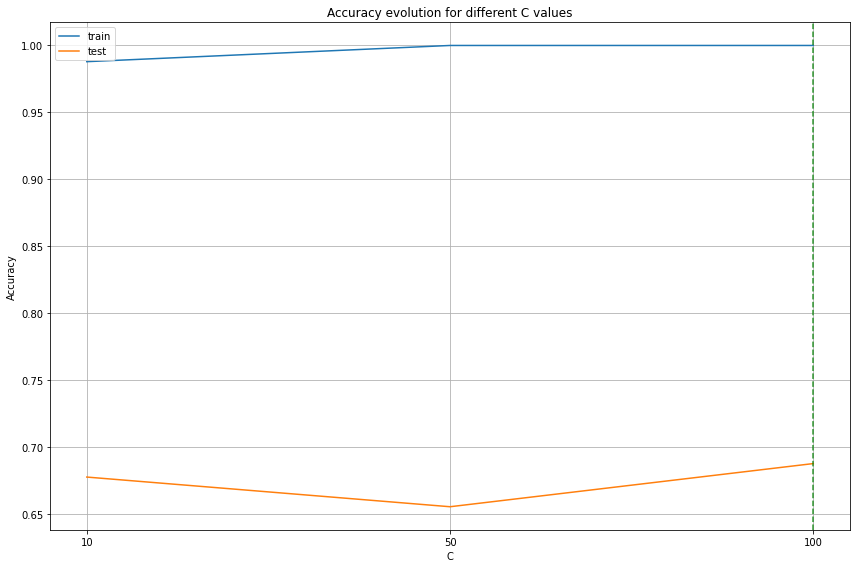

In [90]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()

plt.show()

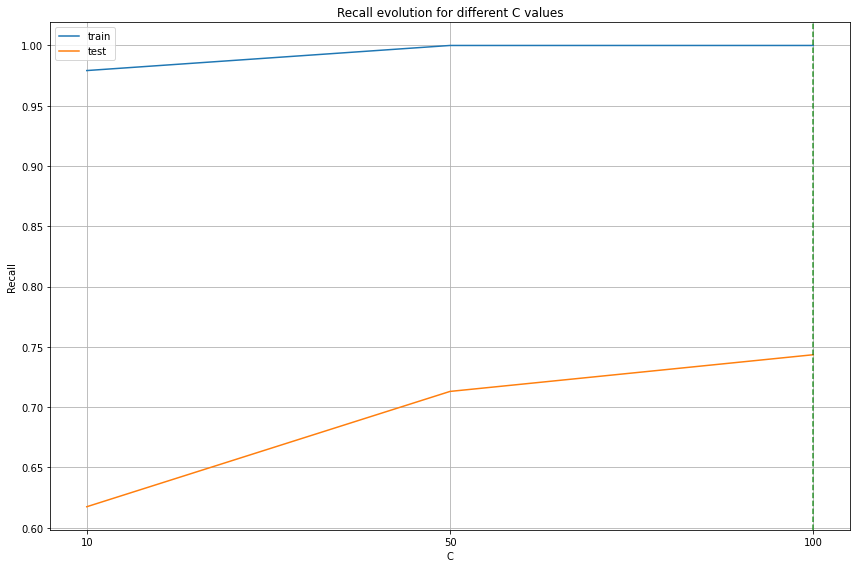

In [91]:
plt.figure(figsize=(12, 8))
plt.plot(train_recall, label='train')
plt.plot(test_recall, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Recall evolution for different C values')
plt.xlabel('C')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()

plt.show()

In [92]:
reviews['processed_text'] = reviews['reviewText'].apply(lambda text: text_normalizer(text=text, lemmas_dict=english_lemmas_dict, sw_list=sw_list))

C:\Users\Seven\AppData\Local\Temp\ipykernel_8860\1405305023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['processed_text'] = reviews['reviewText'].apply(lambda text: text_normalizer(text=text, lemmas_dict=english_lemmas_dict, sw_list=sw_list))


In [93]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_, y_train)

RandomForestClassifier(n_estimators=50)

In [94]:
def predict_review_sentiment(review_index, model):
    print(f"Actual sentiment: {reviews.iloc[review_index]['sentiment']}")
    r = reviews.iloc[review_index]['processed_text']
    print(f"Prediction: {rf.predict(cv.transform([r]))}")

In [95]:
for i in random.sample(range(0, len(reviews)), 10):
    print(f"\nReview no. {i}")
    predict_review_sentiment(i, rf)


Review no. 1002
Actual sentiment: 1
Prediction: [0]

Review no. 9486
Actual sentiment: 1
Prediction: [0]

Review no. 1082
Actual sentiment: 1
Prediction: [1]

Review no. 6091
Actual sentiment: 1
Prediction: [1]

Review no. 3732
Actual sentiment: 1
Prediction: [1]

Review no. 2637
Actual sentiment: 1
Prediction: [1]

Review no. 1999
Actual sentiment: 1
Prediction: [0]

Review no. 9518
Actual sentiment: 1
Prediction: [1]

Review no. 2702
Actual sentiment: 1
Prediction: [0]

Review no. 6911
Actual sentiment: 1
Prediction: [0]


# Conclusión

> He usado un Random Forest porque es el modelo que mejor resultado obtenía en el notebook anterior, sin embargo, con un mejor preprocesado, etc, podríamos obtener un mejor accuracy.

> La opción de usar deep learning es también bastante interesante. Existen modelos como Convolutional Neural Networks o Recurrent Neural Networks que permiten un buen compromiso entre precisión, velocidad y coste. Probar con estas técnicas supondría una mejora de nuestro ejercicio.

> Existen diversos cambios que se podrían hacer para mejorar la acuracy, como por ejemplo eliminar del corpus la valoración de 3 estrellas, añadir es usar una lista de stop words más adecuada para el corpus que estamos tratando, etc.

> La calidad de los datos ingestados en el modelo tienen mucho impacto el la accuracy:
> - Una de ellas es usar una exhaustiva lista de stop words, ésta dependerá del lenguaje y debería ser adaptada para cada corpus en concreto para obtener mejor resultados.
>
> - Otra es eliminar el ruido del corpus, esto incluye eliminar signos de puntuación, valores numéricos, links, etc, que pueden ensuciar nuestro corpus.
>
> - Eliminar features que tengan muy poca frecuencia. Existen algunas features que deben ser eliminadas si ocurren muy pocas veces en todo el corpus. Esto, en general, se ha asociado a una mejora en el modelo.

> Una vez que el modelo sea robusto, y se haya limpiado y normalizado de forma adecuada, una prueba de validación sería comprobar el modelo que hemos hecho con otro corpus distinto para ver en qué medida el modelo funciona.